# Training

This treats the spectrograms of the words like images

In [1]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

In [2]:
# Load the TensorBoard notebook extension - if you want it inline - this can be a bit flaky...
# %load_ext tensorboard
# %reload_ext tensorboard

In [3]:
wake_word = 'hikiwi'
train_cache_file_name = "/tmp/wake-word-cache/train-data"
valid_cache_file_name = "/tmp/wake-word-cache/valid-data"
test_cache_file_name = "/tmp/wake-word-cache/test-data"

In [4]:
# clear out any old logs
!rm -rf ./logs/ 
!rm -rf /tmp/wake-word-cache/

In [5]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('merged-training_spectrogram.npz')
validation_spectrogram = np.load('merged-validation_spectrogram.npz')
test_spectrogram = np.load('merged-test_spectrogram.npz')

In [6]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train_cats = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate_cats = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test_cats = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [7]:
# plot a distribution of the words
# plt.hist(Y_train_cats, bins=range(0,len(words)+1), align='left')

In [8]:
unique, counts = np.unique(Y_train_cats, return_counts=True)
print(unique, counts)
dict(zip([i for i in unique], counts))

['_background' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'follow' 'forward' 'four' 'go' 'happy' 'hikiwi' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero'] [51625   635   683   734   655   725  1387  1373  1471   591   603  1331
  1332   709 33618   779   540  1410   720  1438  1438  1390  1398  1396
  1291  1462   712  1386  1423  1352   564  1442  1229   593   722  1475
  1506]


{'_background': 51625,
 'backward': 635,
 'bed': 683,
 'bird': 734,
 'cat': 655,
 'dog': 725,
 'down': 1387,
 'eight': 1373,
 'five': 1471,
 'follow': 591,
 'forward': 603,
 'four': 1331,
 'go': 1332,
 'happy': 709,
 'hikiwi': 33618,
 'house': 779,
 'learn': 540,
 'left': 1410,
 'marvin': 720,
 'nine': 1438,
 'no': 1438,
 'off': 1390,
 'on': 1398,
 'one': 1396,
 'right': 1291,
 'seven': 1462,
 'sheila': 712,
 'six': 1386,
 'stop': 1423,
 'three': 1352,
 'tree': 564,
 'two': 1442,
 'up': 1229,
 'visual': 593,
 'wow': 722,
 'yes': 1475,
 'zero': 1506}

In [9]:
Y_train = [1 if y == wake_word else 0 for y in Y_train_cats]
Y_validate = [1 if y == wake_word else 0 for y in Y_validate_cats]
Y_test = [1 if y == wake_word else 0 for y in Y_test_cats]

In [10]:
Y_train_cats=[]
Y_validate_cats=[]
Y_test_cats=[]
training_spectrogram = None
validation_spectrogram = None
test_spectrogram = None

(array([89520., 33618.]),
 array([0., 1., 2.]),
 <BarContainer object of 2 artists>)

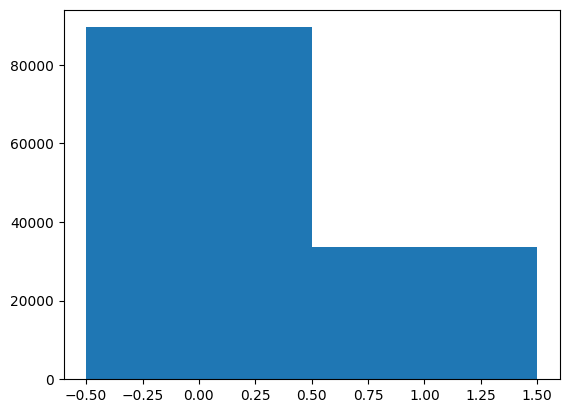

In [11]:
plt.hist(Y_train, bins=range(0,3), align='left')

In [12]:
# create the datasets for training
batch_size = 32

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    2048, reshuffle_each_iteration=True
).batch(
    batch_size
)

# validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0])

# test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))



2023-05-02 02:14:07.824254: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3155780664 exceeds 10% of free system memory.


In [13]:
validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(128)

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(128)

2023-05-02 02:14:09.749469: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 787779092 exceeds 10% of free system memory.
2023-05-02 02:14:10.238754: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 790880080 exceeds 10% of free system memory.


In [14]:
# model = Sequential([
#     Conv2D(4, 3, 
#            padding='same',
#            activation='relu',
#            kernel_regularizer=regularizers.l2(0.001),
#            name='conv_layer1',
#            input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
#     MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
#     Conv2D(4, 3, 
#            padding='same',
#            activation='relu',
#            kernel_regularizer=regularizers.l2(0.001),
#            name='conv_layer2'),
#     MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
#     Flatten(),
#     Dropout(0.2),
#     Dense(
#         40,
#         activation='relu',
#         kernel_regularizer=regularizers.l2(0.001),
#         name='hidden_layer1'
#     ),
#     Dense(
#         1, 
#         activation='sigmoid',
#         kernel_regularizer=regularizers.l2(0.001),
#         name='output'
#     )
# ])

model = Sequential([
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
#     MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    tf.keras.layers.Reshape((IMG_WIDTH, 43*4)),
    tf.keras.layers.GRU(32, dropout=0.3),
    Dense(
        32,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
#     Dropout(0.2),
#     Dense(
#         32,
#         activation='relu',
#         kernel_regularizer=regularizers.l2(0.001),
#         name='hidden_layer2'
#     ),
    Dense(
        1, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 149, 43, 4)        40        
                                                                 
 reshape (Reshape)           (None, 149, 172)          0         
                                                                 
 gru (GRU)                   (None, 32)                19776     
                                                                 
 hidden_layer1 (Dense)       (None, 32)                1056      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 20,905
Trainable params: 20,905
Non-trainable params: 0
_________________________________________________________________


In [15]:
epochs=30

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data

In [16]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model

In [17]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint-v2.model",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=1,
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)

2023-05-02 02:14:11.344844: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3155780664 exceeds 10% of free system memory.


Epoch 1/30
3848/3848 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9738

2023-05-02 02:26:26.977944: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 787779092 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


INFO:tensorflow:Assets written to: checkpoint-v2.model/assets


3848/3848 [==============================] - 740s 191ms/step - loss: 0.0752 - accuracy: 0.9738 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 2/30
3848/3848 [==============================] - 728s 189ms/step - loss: 0.0133 - accuracy: 0.9988 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 3/30
3848/3848 [==============================] - 726s 189ms/step - loss: 0.0108 - accuracy: 0.9991 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 4/30
3848/3848 [==============================] - 727s 189ms/step - loss: 0.0094 - accuracy: 0.9994 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 5/30
3848/3848 [==============================] - 724s 188ms/step - loss: 0.0080 - accuracy: 0.9996 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 6/30
3848/3848 [==============================] - 723s 188ms/step - loss: 0.0078 - accuracy: 0.9996 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 7/30
3848/3848 [==============================] - 726s 189ms/step - loss: 0.0066 - accuracy: 0.9998 - val_loss: 0.005

In [18]:
model.save("trained-v2.model")

INFO:tensorflow:Assets written to: trained-v2.model/assets


INFO:tensorflow:Assets written to: trained-v2.model/assets


# Testing the Model

In [19]:
model2 =  keras.models.load_model("checkpoint-v2.model")

In [20]:
results = model2.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=128)

242/242 [==============================] - 37s 152ms/step - loss: 0.0118 - accuracy: 0.9996


In [ ]:
predictions = model2.predict_on_batch(X_test)
decision = [1 if p > 0.5 else 0 for p in predictions]
tf.math.confusion_matrix(Y_test, decision)

In [ ]:
predictions = model2.predict_on_batch(X_test)
decision = [1 if p > 0.9 else 0 for p in predictions]
tf.math.confusion_matrix(Y_test, decision)

# Fully train the model

In [ ]:
complete_train_X = np.concatenate((X_train, X_validate, X_test))
complete_train_Y = np.concatenate((Y_train, Y_validate, Y_test))

complete_train_dataset = Dataset.from_tensor_slices((complete_train_X, complete_train_Y)).repeat(count=-1).shuffle(300000).batch(batch_size)

In [ ]:
history = model2.fit(
    complete_train_dataset,
    steps_per_epoch=len(complete_train_X) // batch_size,
    epochs=5
)

In [ ]:
print(history)

In [ ]:
# predictions = model2.predict_on_batch(complete_train_X)
# decision = [1 if p > 0.5 else 0 for p in predictions]
# tf.math.confusion_matrix(complete_train_Y, decision)

In [ ]:
# decision = [1 if p > 0.95 else 0 for p in predictions]
# tf.math.confusion_matrix(complete_train_Y, decision)

In [ ]:
# model2.save("fully_trained.model")